[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/NREL/rlmolecule/blob/main/examples/benchmarks/RL_workshop.ipynb)

# Install and import dependencies

In [ ]:
!pip install rdkit rlmolecule matplotlib

In [1]:
import graphenv
import matplotlib.pyplot as plt
import nfp
import numpy as np
import ray
import rdkit
import rdkit.Chem.Draw
import rlmolecule
from ray.rllib.utils.framework import try_import_tf
from tqdm import tqdm

print(f"ray: {ray.__version__}")
print(f"graphenv: {graphenv.__version__}")
print(f"nfp: {nfp.__version__}")
print(f"rlmolecule: {rlmolecule.__version__}")
print(f"rdkit: {rdkit.__version__}")

tf1, tf, tfv = try_import_tf()
num_gpus = len(tf.config.list_physical_devices("GPU"))
print(f"Using {num_gpus} GPUs")

%matplotlib inline

ray: 2.3.1
graphenv: 0.2.5.dev0+gcd40208.d20230421
nfp: 0.3.12
rlmolecule: 0.0.7.dev1+ga5dcd5c.d20230329
rdkit: 2022.09.5
Using 0 GPUs


# Molecule Builder

In [2]:
from rlmolecule.builder import MoleculeBuilder

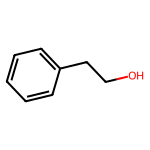

In [3]:
starting_mol = rdkit.Chem.MolFromSmiles("c1ccc(cc1)CCO")
rdkit.Chem.Draw.MolToImage(starting_mol, size=(150,150))

## Basic Functionality
The builder object adds all possible bond and atom types at each position along a given starting molecule.

29 derived molecules


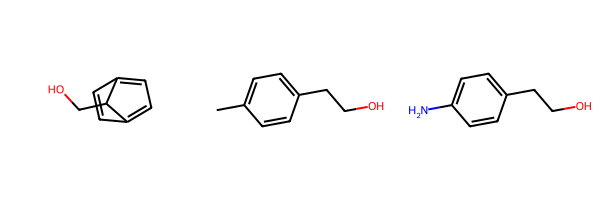

In [4]:
builder = MoleculeBuilder()
next_mols = builder(starting_mol)
print(f"{len(next_mols)} derived molecules")
rdkit.Chem.Draw.MolsToGridImage(next_mols[:3])

The [MoleculeBuilder documentation](https://github.com/NREL/rlmolecule/blob/main/rlmolecule/builder.py#L52-L73) lists the different options that can be set as well as their default values. We will walk through a few of these options below.

Documentation copied here for reference:

Args:
  -  max_atoms (int, optional): Maximum number of heavy atoms. Defaults to 10.
  -  min_atoms (int, optional): minimum number of heavy atoms. Defaults to 4.
  -  atom_additions (Optional[List], optional): potential atom types to consider.
        Defaults to ('C', 'N', 'O')
  -  stereoisomers (bool, optional): whether to consider stereoisomers different
        molecules. Defaults to False.
  -  canonicalize_tautomers (bool, optional): Whether to use RDKit's tautomer
        canonicalization functionality. Defaults to False.
  -  sa_score_threshold (Optional[float], optional): If set, don't construct
    molecules greater than a given sa_score. Defaults to None.
  -  try_embedding (bool, optional): Try to get a 3D embedding of the molecule,
        and if this fails, remote it. Defaults to False.
  -  cache (bool, optional): Whether to cache molecule building for a given
        SMILES input to speed up subsequent evaluations. Defaults to False.
  -  parallel (bool, optional): (Experimental) whether to try multiprocessing to
        speed up execution for large molecules. Defaults to False.
  -  gdb_filter (bool, optional): Whether to apply filters from the gdb17 paper.
        Defaults to True.


## SA Score Filtering
The Synthetic Accessibility (SA) score was developed by Ertl and Schauffner ([J. Cheminfom, 2009](https://doi.org/10.1186/1758-2946-1-8)) to estimate the ease of synthesis of drug-like molecules based on the complexity and fingerprints of the molecule. They provide an implementation packaged with RDKit called [sascorer.py](https://github.com/rdkit/rdkit/blob/master/Contrib/SA_Score/sascorer.py). 

Setting the `sa_score_threshold` will filter out molecules with scores above the specified cutoff.



28 derived molecules


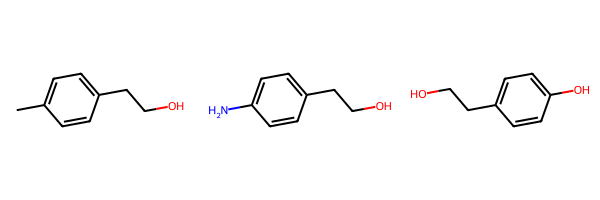

In [5]:
next_mols_sa = MoleculeBuilder(sa_score_threshold=4.0)(starting_mol)
print(f"{len(next_mols_sa)} derived molecules")
rdkit.Chem.Draw.MolsToGridImage(next_mols_sa[:3])

## Stereochemistry Enumeration
Stereoisomers are molecules with the same structural formula but with a different arrangement of atoms in space. See [wikipedia](https://en.wikipedia.org/wiki/Skeletal_formula#Stereochemistry) for examples.

To consider stereoisomers as different molecules, set `stereoisomers=True`

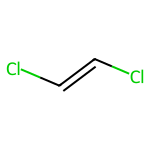

In [6]:
starting_mol = rdkit.Chem.MolFromSmiles("C(Cl)=C(Cl)")
rdkit.Chem.Draw.MolToImage(starting_mol, size=(150,150))

6 derived molecules


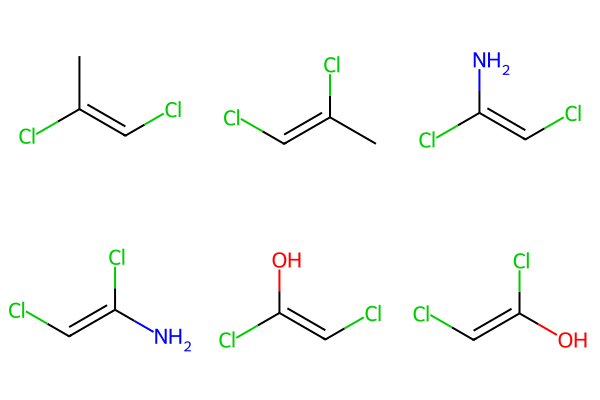

In [7]:
next_mols = MoleculeBuilder(stereoisomers=True)(starting_mol)
print(f"{len(next_mols)} derived molecules")
rdkit.Chem.Draw.MolsToGridImage(next_mols)

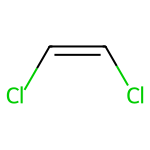

In [8]:
starting_mol = rdkit.Chem.MolFromSmiles("Cl/C=C\Cl")
rdkit.Chem.Draw.MolToImage(starting_mol, size=(150,150))

3 derived molecules


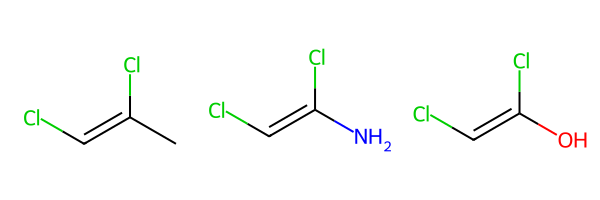

In [9]:
next_mols = MoleculeBuilder(stereoisomers=True)(starting_mol)
print(f"{len(next_mols)} derived molecules")
rdkit.Chem.Draw.MolsToGridImage(next_mols[:3])

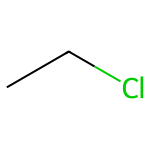

In [10]:
starting_mol = rdkit.Chem.MolFromSmiles("C(C)(Cl)")
rdkit.Chem.Draw.MolToImage(starting_mol, size=(150,150))

16 derived molecules


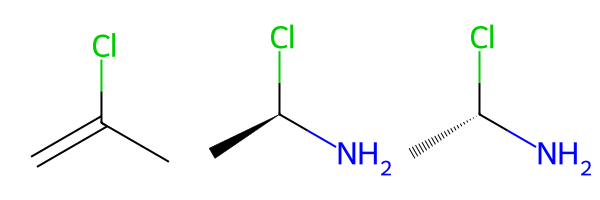

In [11]:
next_mols = MoleculeBuilder(stereoisomers=True)(starting_mol)
print(f"{len(next_mols)} derived molecules")
rdkit.Chem.Draw.MolsToGridImage(next_mols[1:4])

## Tautomer Enumeration
Tautomers are structural isomers of chemical compounds that readily interconvert.

To use RDKit's [tautomer canonicalization](https://www.rdkit.org/docs/source/rdkit.Chem.MolStandardize.rdMolStandardize.html#rdkit.Chem.MolStandardize.rdMolStandardize.TautomerEnumerator.Enumerate) functionality, set `canonicalize_tautomers=True`

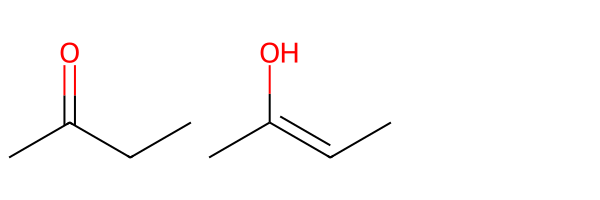

In [12]:
mol1 = rdkit.Chem.MolFromSmiles("CC(CC)=O")
mol2 = rdkit.Chem.MolFromSmiles("CC(O)=CC")
rdkit.Chem.Draw.MolsToGridImage([mol1, mol2])

33 derived molecules


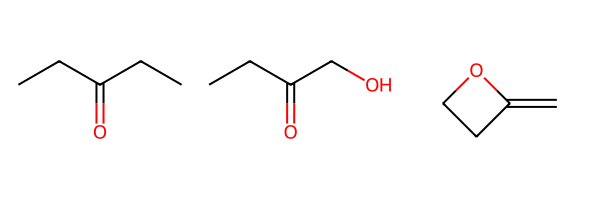

In [13]:
next_mols = MoleculeBuilder(canonicalize_tautomers=True)(
    rdkit.Chem.MolFromSmiles("CC(CC)=O")
)
print(f"{len(next_mols)} derived molecules")
rdkit.Chem.Draw.MolsToGridImage(next_mols[::3][:3])

Next molecules for different forms of the same tautomers are identical

In [14]:
mol1 = rdkit.Chem.MolFromSmiles("CC(CC)=O")
mol2 = rdkit.Chem.MolFromSmiles("CC(O)=CC")

builder = MoleculeBuilder(canonicalize_tautomers=True)
product_smiles = lambda mol: set([rdkit.Chem.MolToSmiles(mol) for mol in builder(mol)])

assert product_smiles(mol1) == product_smiles(mol2)

# MoleculeState
Now we will go over how to represent molecules for GNN-based reinforcement learning

In [nfp](https://github.com/NREL/nfp) (and most other GNN libraries) molecules are represented as integer arrays containing their atom classes, bond classes, and a sparse connectivity matrix

In [15]:
from rlmolecule.policy.preprocessor import load_preprocessor

preprocessor = load_preprocessor()
preprocessor(rdkit.Chem.MolFromSmiles("CCO"))

{'atom': array([ 8, 10, 18]),
 'bond': array([ 3,  3,  9, 10]),
 'connectivity': array([[0, 1],
        [1, 0],
        [1, 2],
        [2, 1]])}

The `MoleculeState` class extends the GraphEnv [`Vertex`](https://nrel.github.io/graph-env/_autosummary/graphenv.vertex.Vertex.html#graphenv.vertex.Vertex) class to combine building next actions and getting the current state's observation matrix. In addition, we must define a *reward* function used to score generated molecules.

As an example reward, we use the QED score, which is the Quantitative Estimate of Drug-likeness implemented in rdkit: [rdkit.Chem.QED](https://www.rdkit.org/docs/source/rdkit.Chem.QED.html). The first paragraph is copied here for reference:
> QED stands for quantitative estimation of drug-likeness and the concept was for the first time introduced by Richard Bickerton and coworkers [1]. The empirical rationale of the QED measure reflects the underlying distribution of molecular properties including molecular weight, logP, topological polar surface area, number of hydrogen bond donors and acceptors, the number of aromatic rings and rotatable bonds, and the presence of unwanted chemical functionalities.

> [1] Bickerton, G.R.; Paolini, G.V.; Besnard, J.; Muresan, S.; Hopkins, A.L. (2012)
‘Quantifying the chemical beauty of drugs’, Nature Chemistry, 4, 90-98 [https://doi.org/10.1038/nchem.1243]

In [16]:
from rdkit.Chem.QED import qed
from rlmolecule.molecule_state import MoleculeData, MoleculeState


class QEDState(MoleculeState):
    @property
    def reward(self) -> float:
        if self.forced_terminal:
            reward = qed(self.molecule)
            self.data.log_reward([self.smiles, reward])
            return reward

        else:
            return 0.0

`MoleculeBuilder` parameters and other configuration details are stored in a python `dataclass`, which simplifies passing parameter from parent to child `MoleculeState`s

In [17]:
qed_data = MoleculeData(
    MoleculeBuilder(max_atoms=10, cache=True, gdb_filter=False), max_num_actions=32
)

Next states are built lazily upon accessing the `.children` property.

In [18]:
qed_state = QEDState(rdkit.Chem.MolFromSmiles("C"), qed_data)

qed_state.children

[CC, C=C, C#C, CN, C=N, C#N, CO, C=O, C (t)]

In [19]:
qed_state.children[1].children

[C=CC, C=C=C, C=CN, C=C=N, C=CO, C=C=O, C=C (t)]

The final action is typically to return the current molecule as a *terminal* state, i.e. to stop molecule construction and return a reward

In [20]:
terminal_state = qed_state.children[1].children[-1]
terminal_state

C=C (t)

In [21]:
terminal_state.reward

0.34449676855385364

The *observation space* of the molecule state is essentially a padded version of our preprocessed values above, to account for molecule batching

In [22]:
qed_state.observation_space["atom"]

Box(0, 193, (10,), int64)

In [23]:
qed_state.children[0].children[6]  # Ethanol

CCO

In [24]:
qed_state.children[0].children[6].observation["atom"]

array([ 8, 10, 18,  0,  0,  0,  0,  0,  0,  0])

# GraphEnv
The *GraphEnv* batches together molecule states in an OpenAI [gymnasium](https://gymnasium.farama.org/)-compatible environment 

In [25]:
from graphenv.graph_env import GraphEnv

env = GraphEnv({"state": qed_state, "max_num_children": qed_state.max_num_actions})

In [26]:
# Here, obs is a list of MoleculeState observations, with the first entry corresponding to the parent node
obs, info = env.reset()

We can randomly sample from possible paths through the environment as follows:

In [27]:
done = False
obs, info = env.reset()
np.random.seed(0)
print(env.state)

while not done:
   action = np.random.choice(len(env.state.children))
   obs, reward, terminated, truncated, info = env.step(action)
   done = terminated or truncated
   print(env.state)

C
C#N
CC#N
N#CCN
N#CCN=O
N#CC(=N)N=O
N#CC(=N)N=O (t)


# Molecule Model

Initializes a GNN policy model used to score in-progress molecules. Outputs both a predicted value of the current state, and the likelihood this state should be chosen from a list of next possible states.

https://github.com/NREL/rlmolecule/blob/main/rlmolecule/policy/model.py

In [28]:
from rlmolecule.policy.model import policy_model

In [29]:
model = policy_model()
obs, info = env.reset()

In [30]:
batched_inputs = {key: np.stack([entry[key] for entry in obs]) for key in obs[0].keys()}

In [31]:
model(batched_inputs)

[<tf.Tensor: shape=(10, 1), dtype=float32, numpy=
 array([[ 0.02024916],
        [ 0.0339944 ],
        [ 0.09803371],
        [-0.01323655],
        [-0.01666463],
        [ 0.10623474],
        [-0.00744034],
        [ 0.03500051],
        [ 0.06306621],
        [ 0.02024916]], dtype=float32)>,
 <tf.Tensor: shape=(10, 1), dtype=float32, numpy=
 array([[ 0.04257252],
        [-0.09207147],
        [-0.04504566],
        [-0.0321888 ],
        [-0.0409211 ],
        [-0.04497342],
        [-0.08515189],
        [-0.06217989],
        [-0.08845027],
        [ 0.04257252]], dtype=float32)>]

# Running RLLib

A small scale example of running RLLib in the notebook, although longer simulation times are typically required. 

For more details about about rllib, see https://docs.ray.io/en/latest/rllib/index.html

In [32]:
from ray.tune.registry import register_env
from rlmolecule.molecule_model import MoleculeModel

In [33]:
def create_env(config):
    """When not running in local_mode, there are often issues in allowing ray to copy
    `MoleculeState` to distribute the environment on worker nodes, since actor handles
    are copied and not initialized correctly.
    To solve this, it's best to delay `MoleculeState` (and the dataclass) initialization
    until needed on each ray worker through the `register_env` method.
    Here, we create and return an initialized `GraphEnv` object.
    """

    qed_data = MoleculeData(
        MoleculeBuilder(max_atoms=10, cache=True, gdb_filter=False),
        max_num_actions=32,
        prune_terminal_states=True,
    )

    qed_state = QEDState(
        rdkit.Chem.MolFromSmiles("C"),
        qed_data,
        smiles="C",
    )
    return GraphEnv({"state": qed_state, "max_num_children": qed_state.max_num_actions})


# This registers the above function with rllib, such that we can pass only "QEDGraphEnv"
# as our env object in `tune.run()`
register_env("QEDGraphEnv", lambda config: create_env(config))

In [34]:
# Proximal Policy Optimization algorithm (PPO)

from ray.rllib.agents.ppo import PPOTrainer

config = {
    "env": "QEDGraphEnv",
    "model": {
        "custom_model": MoleculeModel,
        "custom_model_config": {
            "preprocessor": load_preprocessor(),
            "features": 32,
            "num_messages": 1,
        },
    },
    "num_workers": 1,
    "num_gpus": 1 if num_gpus >= 1 else 0,
    "framework": "tf2",
    "eager_tracing": True,
    "batch_mode": "complete_episodes",
    "gamma": 1.0,
    "lr": 0.01,
    "entropy_coeff": 0.001,
    "num_sgd_iter": 5,
    "train_batch_size": 100,
    "sgd_minibatch_size": 10,
    "rollout_fragment_length": 100,
}

trainer = PPOTrainer(config=config)

2023-05-08 15:35:41,918	INFO worker.py:1553 -- Started a local Ray instance.
2023-05-08 15:35:54,583	WARNING worker.py:1866 -- It looks like you're creating a detached actor in an anonymous namespace. In order to access this actor in the future, you will need to explicitly connect to this namespace with ray.init(namespace="a0330de4-6b59-4643-972e-edb6419f6c96", ...)
2023-05-08 15:35:54,597	WARNING worker.py:1866 -- It looks like you're creating a detached actor in an anonymous namespace. In order to access this actor in the future, you will need to explicitly connect to this namespace with ray.init(namespace="a0330de4-6b59-4643-972e-edb6419f6c96", ...)
(RolloutWorker pid=69384) 2023-05-08 15:35:54,598	WARNING env.py:156 -- Your env doesn't have a .spec.max_episode_steps attribute. Your horizon will default to infinity, and your environment will not be reset.
2023-05-08 15:35:57,996	INFO trainable.py:172 -- Trainable.setup took 19.623 seconds. If your trainable is slow to initialize, co

  0%|                                                                                                     | 0/5 [00:00<?, ?it/s](RolloutWorker pid=11334) /home/pstjohn/mambaforge/envs/graphenv/lib/python3.9/site-packages/numpy/core/_methods.py:180: RuntimeWarning: overflow encountered in reduce
(RolloutWorker pid=11334)   ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
2022-11-22 10:17:55,985	WARNING deprecation.py:46 -- DeprecationWarning: `_get_slice_indices` has been deprecated. This will raise an error in the future!
2022-11-22 10:17:55,986	WARNING deprecation.py:46 -- DeprecationWarning: `slice` has been deprecated. Use `SampleBatch[start:stop]` instead. This will raise an error in the future!
/home/pstjohn/mambaforge/envs/graphenv/lib/python3.9/site-packages/numpy/core/_methods.py:180: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
100%|███████████████████████████████████████████████████████████████████████

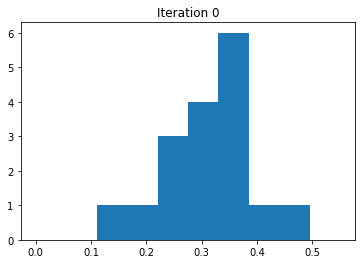

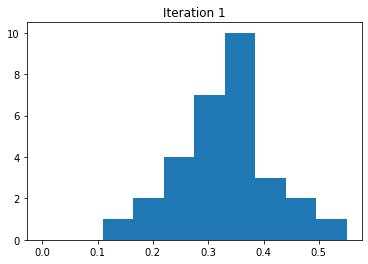

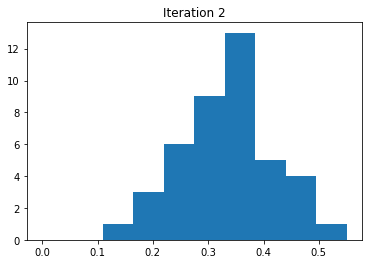

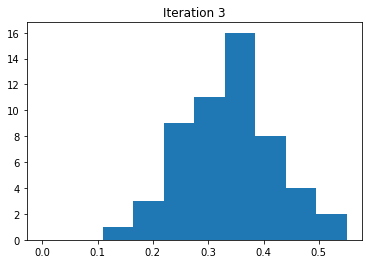

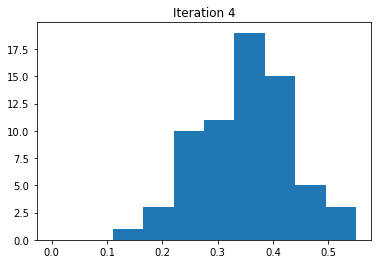

In [35]:
# Train the policy for 5 iterations.
# Each train iteration samples the environment for <config.train_batch_size> steps 
for i in tqdm(range(5)):
    results = trainer.train()

    plt.figure(figsize=(4,4))
    plt.hist(
        np.array(results["sampler_results"]["hist_stats"]["episode_reward"]),
        range=(0, 0.55),
    )
    plt.title(f"Iteration {i}")
    plt.ylabel("# Episodes")
    plt.xlabel("Reward")

# Interrogating a trained policy model

In [36]:
from ray.rllib.models.preprocessors import get_preprocessor

env_preprocessor = get_preprocessor(env.observation_space)(env.observation_space)
policy = trainer.get_policy()
obs, info = env.reset()

In [37]:
[str(c) for c in env.state.children]

['CC', 'C=C', 'C#C', 'CN', 'C=N', 'C#N', 'CO', 'C=O', 'C (t)']

This `get_action_logits` function shows how to get the raw logit values output by the policy model for the next actions. We can apply a softmax to them to get a probability distribution.

For a good disucssion about what logits are, see this stack overflow post: https://stackoverflow.com/a/43577384/7483950

In [38]:
def get_action_logits(env: GraphEnv):

    obs = env.make_observation()

    logits = policy.model({"obs": env_preprocessor.transform(obs)[None, :]})[0].numpy()[
        0, : len(obs) - 1
    ]

    return {
        str(state): (i, logit)
        for state, (i, logit) in reversed(
            sorted(zip(env.state.children, enumerate(logits)), key=lambda x: x[1][1])
        )
    }

The action with the largest score would be most likely chosen by the RL algorithm

In [39]:
get_action_logits(env)

{'CC': (0, 1.0851789),
 'C (t)': (8, 0.70855594),
 'C#N': (5, 0.57979286),
 'C=C': (1, 0.21868715),
 'CO': (6, 0.16918644),
 'C=N': (4, 0.14426081),
 'C#C': (2, 0.040710025),
 'C=O': (7, -0.04485144),
 'CN': (3, -0.3226827)}

In [40]:
# Here we select the action at index 4 (C=N)
env.step(4)
get_action_logits(env)

{'CC=N': (0, 0.39846912),
 'C=N (t)': (9, 0.14426081),
 'C=C=N': (1, 0.036876246),
 'N=C=N': (3, -0.26052696),
 'N=CN': (2, -0.39088646),
 'N=C=O': (5, -0.398442),
 'N=CO': (4, -0.4902005),
 'C=NC': (6, -1.3022612),
 'C=NO': (8, -2.9633045),
 'C=NN': (7, -3.957326)}

In [41]:
env.step(0)
get_action_logits(env)

{'CCC=N': (1, 0.83730257),
 'CC(C)=N': (9, 0.40714657),
 'CC=N (t)': (15, 0.39846912),
 'C=CC=N': (2, 0.07068136),
 'N=CCO': (7, 0.012421417),
 'CC(=N)N': (10, -0.041195434),
 'N=CC=N': (5, -0.044224557),
 'N=CCN': (4, -0.20399898),
 'N=CC=O': (8, -0.21383363),
 'N#CC=N': (6, -0.28930357),
 'CC(=N)O': (11, -0.41037074),
 'C#CC=N': (3, -0.549032),
 'C1=NC1': (0, -0.6806818),
 'CC=NC': (12, -0.96610165),
 'CC=NO': (14, -2.2118237),
 'CC=NN': (13, -2.9573398)}

In [42]:
env.step(5)
get_action_logits(env)

{'CC(=N)C=N': (5, 0.024996048),
 'N=CC=N (t)': (8, -0.044224557),
 'N=CC(=N)N': (6, -0.34910038),
 'N=CC(=N)O': (7, -0.62990594),
 'CN=CC=N': (2, -1.0311629),
 'N=CC=NO': (4, -2.0277405),
 'N=CC=NN': (3, -2.6241531),
 'N=c1cn1': (0, -3.5818782),
 'C1=NN=C1': (1, -5.9641294)}

In [43]:
# The action at the last index (here 8) is to terminate building and calculate the reward
env.state.children[8].reward

0.4054240969465395

# Results for running for ~1hr on a GPU-node
Running on a GPU-node for about 1hr (and a larger maximum molecule size), the model learns pretty quickly how to build molecules with large QED scores. The largest possible QED score is ~0.95. See https://github.com/NREL/rlmolecule/blob/main/examples/benchmarks/qed/run_qed.py

![qed_rl_results.png](https://github.com/NREL/rlmolecule/raw/main/examples/benchmarks/qed_rl_results.png)